# Spotify NB 1: library 1920-2020
an analysis by Vivika Wilde (wilde.vivika@gmail.com)

# Introduction

The times of video killed the radio star are clearly over but what is it that makes stars nowadays? Attempting to find an answer to this question I have looked at Spotify data from the past 100 years and more specifically tracks from 2019. Using machine learning algorithms popularity was predicted both continuously and in binary classes. Finally, clustering was used to find similarities that could be used in a recommender system.

The data used in this project was found on kaggle (https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks/tasks?taskId=969) and via the Spotify API.


## Variable description

| Variable     | Description | 
| :---        |    :----   |
| acousticness      | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.       |
| artists | The artists who performed the track. Each artist object includes a link in href to more detailed information about the artist. | 
| danceability | Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. |
| duration_ms | 	The duration of the track in milliseconds. |
| energy |	Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. |
| explicit | Whether or not the track has explicit lyrics ( true = yes it does; false = no it does not OR unknown).|
| id | The Spotify ID for the track. |
| instrumentalness|Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. |
| key | The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. |
| liveness | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.  | |
| loudness |The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
| mode |Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. |
| name | 	The name of the track. |
| popularity | The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time. |
| release_date | The date the album the track is on was released. |
| speechiness | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.|
| tempo | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.  |
| valence |	A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). |
| year | The release year of the track. |

# Set up

In [1]:
%reset -fs

In [2]:
import pandas as pd
import numpy as np
import json

from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import time 
from tqdm import tqdm

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
from ast import literal_eval
from pandas.io.json import json_normalize

import plotting

%matplotlib inline
plt.style.use('seaborn')
RSEED=np.random.seed(42)

In [3]:
# loading data that was provided on kaggle
by_artist = pd.read_csv('data/data_by_artist.csv')
by_genre = pd.read_csv('data/data_by_genres.csv')
by_year = pd.read_csv('data/data_by_year.csv')
data_genre = pd.read_csv('data/data_w_genres.csv')
data = pd.read_csv('data/data.csv')
super_genres = json.load(open('data/super_genres.json'))

In [4]:
# comparing the different files
cols = [by_artist.columns, by_genre.columns, by_year.columns, data_genre.columns, data.columns]
cols = pd.DataFrame(cols, index = ["by_artist","by_genre", "by_year",  "data_genre", "data"]).T
[by_artist.shape[0], by_genre.shape[0], by_year.shape[0],  data_genre.shape[0], data.shape[0]]

[27621, 2664, 100, 27621, 169909]

In [5]:
cols

,by_artist,by_genre,by_year,data_genre,data
0,artists,genres,year,artists,acousticness
1,acousticness,acousticness,acousticness,acousticness,artists
2,danceability,danceability,danceability,danceability,danceability
3,duration_ms,duration_ms,duration_ms,duration_ms,duration_ms
4,energy,energy,energy,energy,energy
5,instrumentalness,instrumentalness,instrumentalness,instrumentalness,explicit
6,liveness,liveness,liveness,liveness,id
7,loudness,loudness,loudness,loudness,instrumentalness
8,speechiness,speechiness,speechiness,speechiness,key
9,tempo,tempo,tempo,tempo,liveness


In [6]:
super_genres=json_normalize(super_genres)


/Users/vivika/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [7]:
super_genres

,predictions,score,n_clusters
0,"[[21st century classical, [], a cappella, abst...",0.610389,3
1,"[[432hz, canadian post-rock, histoire pour enf...",0.511357,4
2,"[[abstract, acid jazz, adoracion, afghan pop, ...",0.512782,5
3,"[[21st century classical, a cappella, abstract...",0.527745,6
4,"[[abstract, acid jazz, adoracion, afghan pop, ...",0.483176,7
5,"[[[], abstract hip hop, abstract idm, acid hou...",0.471159,8
6,"[[21st century classical, accordeon, accordion...",0.509244,9
7,"[[432hz, canadian post-rock, magyar, modular s...",0.526022,10
8,"[[histoire pour enfants, microtonal, oratory],...",0.526761,11
9,"[[african gospel, american contemporary classi...",0.526724,12


In [8]:
# the file loaded as data will be used as a basis as it contains track specific data
df=data.copy()
df.sample(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
132259,0.103,['Tracy Chapman'],0.799,181267,0.2740,0,7wBf5LhqfF6A9AVHILTJWi,0.000031,7,0.0961,-18.148,1,If Not Now...,48,1988-04-05,0.0371,108.926,0.530,1988
17849,0.977,"[""Anita O'Day"", 'Oscar Peterson Quartet']",0.648,241000,0.0391,0,25WtkgYzdYCR0n1IsnvnxY,0.000056,9,0.0917,-22.378,1,I've Got The World On A String,16,1957-01-01,0.0372,76.184,0.327,1957
108334,0.983,['Frente Popular'],0.675,95973,0.3660,0,0zNaYXRKM2fPsMSWct7YSK,0.000000,7,0.8420,-7.469,1,Mamita Mia - Remastered,2,1936-03-12,0.1100,96.558,0.667,1936
163389,0.973,"['Giacomo Puccini', 'Maria Callas', 'Herbert v...",0.293,212480,0.1500,0,3lHmvtlqo421jbAfQM1Q2a,0.001090,8,0.1340,-12.880,0,"Puccini: Madama Butterfly, Act 2: ""Che tua mad...",13,1955,0.0400,62.904,0.101,1955
157173,0.765,['Chuck Mangione'],0.560,613040,0.3800,0,450X6juQ93aqSeEfigaWtz,0.710000,0,0.0638,-11.762,1,Maui-Waui,34,1977-12-08,0.0346,80.698,0.389,1977


# Data types

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      169909 non-null  float64
 1   artists           169909 non-null  object 
 2   danceability      169909 non-null  float64
 3   duration_ms       169909 non-null  int64  
 4   energy            169909 non-null  float64
 5   explicit          169909 non-null  int64  
 6   id                169909 non-null  object 
 7   instrumentalness  169909 non-null  float64
 8   key               169909 non-null  int64  
 9   liveness          169909 non-null  float64
 10  loudness          169909 non-null  float64
 11  mode              169909 non-null  int64  
 12  name              169909 non-null  object 
 13  popularity        169909 non-null  int64  
 14  release_date      169909 non-null  object 
 15  speechiness       169909 non-null  float64
 16  tempo             16

The dataset comprises of 169909 instance with no data missing.

In [8]:
# getting some basic statistics on the numerical data
df.describe().round(2)

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,169909.00,169909.00,169909.00,169909.00,169909.00,169909.00,169909.00,169909.00,169909.00,169909.00,169909.00,169909.00,169909.00,169909.00,169909.00
mean,0.49,0.54,231406.16,0.49,0.08,0.16,5.20,0.21,-11.37,0.71,31.56,0.09,116.95,0.53,1977.22
std,0.38,0.18,121321.92,0.27,0.28,0.31,3.52,0.18,5.67,0.45,21.58,0.15,30.73,0.26,25.59
min,0.00,0.00,5108.00,0.00,0.00,0.00,0.00,0.00,-60.00,0.00,0.00,0.00,0.00,0.00,1921.00
25%,0.09,0.42,171040.00,0.26,0.00,0.00,2.00,0.10,-14.47,0.00,12.00,0.03,93.52,0.32,1957.00
50%,0.49,0.55,208600.00,0.48,0.00,0.00,5.00,0.14,-10.47,1.00,33.00,0.04,114.78,0.54,1978.00
75%,0.89,0.67,262960.00,0.71,0.00,0.09,8.00,0.26,-7.12,1.00,48.00,0.08,135.71,0.75,1999.00
max,1.00,0.99,5403500.00,1.00,1.00,1.00,11.00,1.00,3.86,1.00,100.00,0.97,244.09,1.00,2020.00


In [9]:
# getting a first impression of the dataset by viewing a sample
df.sample(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
25803,0.901000,['Hampton Hawes Trio'],0.548,293973,0.236,0,1c9lMLNRbzVfLvbFqV5xNk,0.168000,9,0.282,-18.311,0,Yesterdays,9,1956-01-01,0.0375,88.662,0.307,1956
23103,0.000199,['Big Star'],0.373,168067,0.850,0,731zWsKI2KvdBPO5MWdjSy,0.007700,4,0.124,-4.567,1,September Gurls,43,2009-01-01,0.0342,114.029,0.629,2009
84582,0.047800,['Cinderella'],0.367,287400,0.445,0,01Q4wU19hamqnhNjtuvTyI,0.002840,9,0.163,-13.615,0,Nobody's Fool,60,1986,0.0286,67.197,0.149,1986
158412,0.413000,['Willie Rosario'],0.564,301011,0.526,0,3kqapvD6gg0TlUeqinOX9u,0.001500,1,0.103,-11.918,1,Anuncio Clasificado / Dámelo,42,1990-08-01,0.0453,170.378,0.886,1990
113476,0.161000,['Tiffany'],0.476,261907,0.495,0,5jzDnEoTtwzvJfvVx52rDC,0.000002,1,0.355,-9.949,1,All This Time,54,1988-01-01,0.0301,180.191,0.446,1988


## Popularity

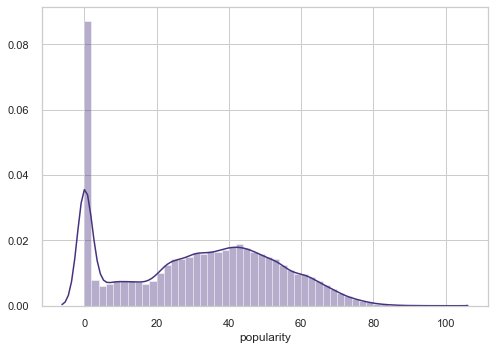

In [10]:
sns.set(style="whitegrid", palette="viridis", color_codes=True)
sns.distplot(df['popularity']);

In [11]:
df['popularity'].describe()

count    169909.000000
mean         31.556610
std          21.582614
min           0.000000
25%          12.000000
50%          33.000000
75%          48.000000
max         100.000000
Name: popularity, dtype: float64

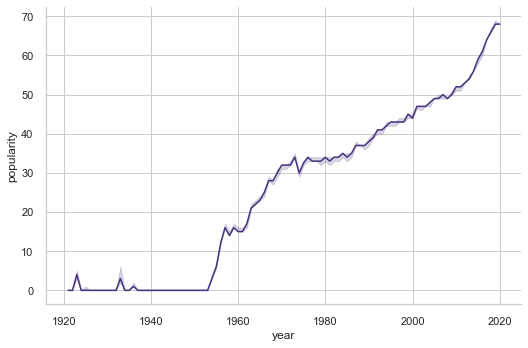

In [12]:
plotting.year_plot("popularity",df)

Popularity data is highly skewed with most of the tracks showing a popularity of 0. Expectedly, older tracks show a lower popularity (today) than more recent releases.

## Age & release time

### Age

In [17]:
df['age'] = df['year'].max()-df['year']

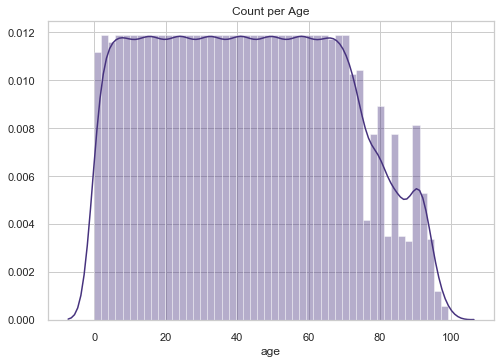

<Figure size 576x396 with 0 Axes>

In [18]:
sns.distplot(df['age'])
plt.title("Count per Age")
plt.show();
plt.savefig('figures/age_dist.png')

As can shown in the graph above, there is less data for tracks that are older than 1950, which is important to note as it could have an impact on the analysis.

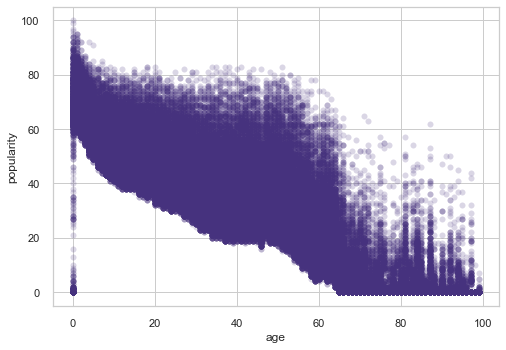

In [19]:
sns.scatterplot(x="age", y="popularity", data=df,
                palette="ch:r=-.2,d=.3_r", alpha=0.2,
                sizes=(1, 8), linewidth=0);
plt.savefig('figures/age_pop_scatter.png')

### Decade

In [20]:
df['decade'] = (np.floor(df['year'] / 10) * 10).astype(int)

### Release month

In [21]:
df['month'] = [int(x.split("-")[1]) if len(x.split("-"))> 1 else None for x in df['release_date']]
missing = pd.DataFrame(df.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/df.shape[0]*100,1)
missing[missing.Number!=0]

,Number,Percentage
month,50382,29.7


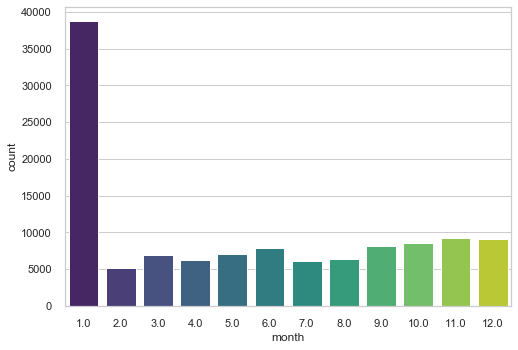

In [22]:
sns.countplot(df['month'],palette='viridis');
plt.savefig('figures/month_count.png')

Most of the tracks in the dataset were released in January, while monthly release numbers are quite similar for the rest of the year.

## Characteristics
### Development over time


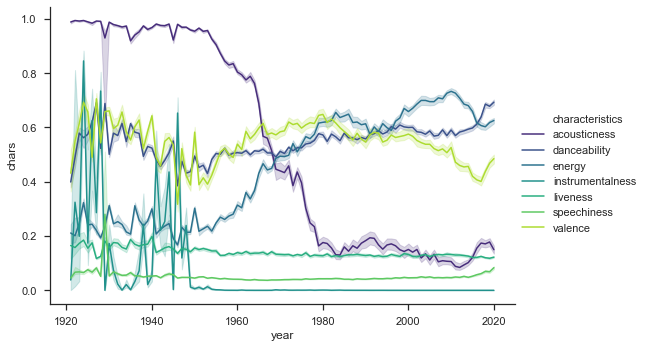

In [23]:
chars = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']

sns.set(style="ticks")
df_graph = pd.melt(df,
                 id_vars=['year'],
                 value_vars= chars,
                 var_name='characteristics',
                 value_name='chars')

palette = dict(zip(chars,
                   sns.color_palette("viridis", 7)))


g = sns.relplot(x='year',
                y="chars",
                hue='characteristics',
                height=5,
                aspect=1.5,
                facet_kws=dict(sharex=False),
                palette=palette,
                kind="line",
                legend="full",
                estimator=np.median,
                data=df_graph)

plt.savefig('figures/year_char_line.png')

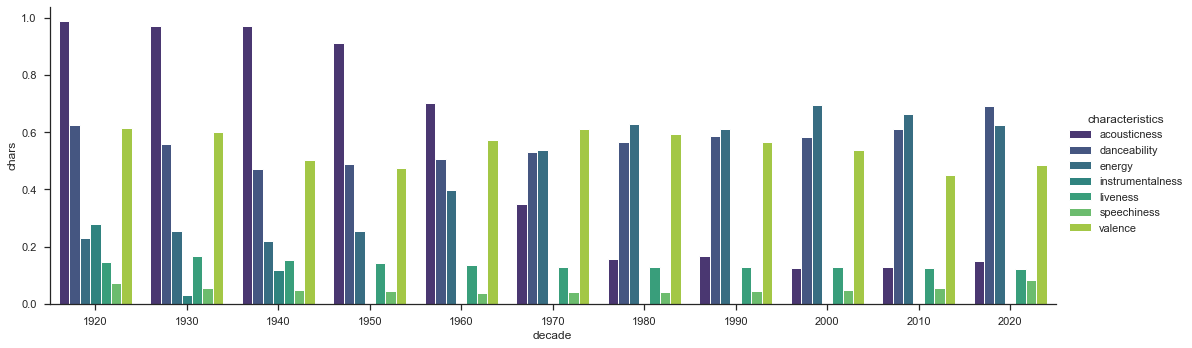

In [24]:
sns.set(style="ticks")
df_graph = pd.melt(df,
                 id_vars=['decade'],
                 value_vars= chars,
                 var_name='characteristics',
                 value_name='chars')

g = sns.catplot(x='decade',
                y="chars",
                hue='characteristics',
                height=5,
                aspect=3,
                kind="bar",
                palette=palette,
                estimator=np.median,
                legend="full",
                ci=None,
                data=df_graph)
plt.savefig('figures/decade_char_bar.png')

### Counts

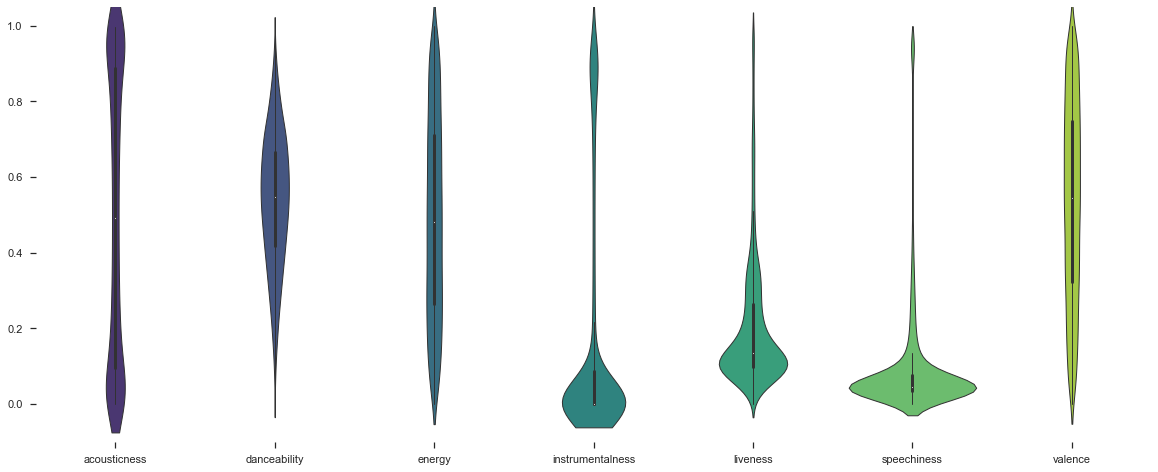

In [25]:
# drawing a violinplot
f, ax = plt.subplots(figsize=(20, 8))
sns.violinplot(data=df[chars], palette="viridis", bw=.2, cut=1, linewidth=1)
ax.set(ylim=(-0.1, 1.05))
sns.despine(left=True, bottom=True)

plt.savefig('figures/char_violine.png')

## Artists

### Since 1920

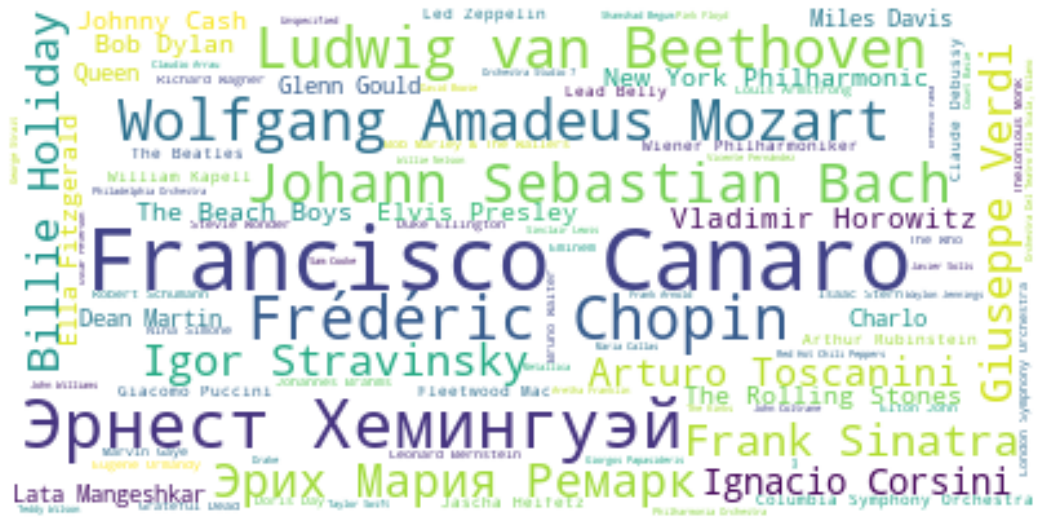

<Figure size 576x396 with 0 Axes>

In [26]:
# creating a dataframe with all artists
artists = df['artists'].str.strip("[]")
artists = artists.str.split("',", expand=True)

# plotting wordcloud using imported file
plotting.wc(artists)
plt.savefig('figures/artist_1920_wc.png')

### Since 2010

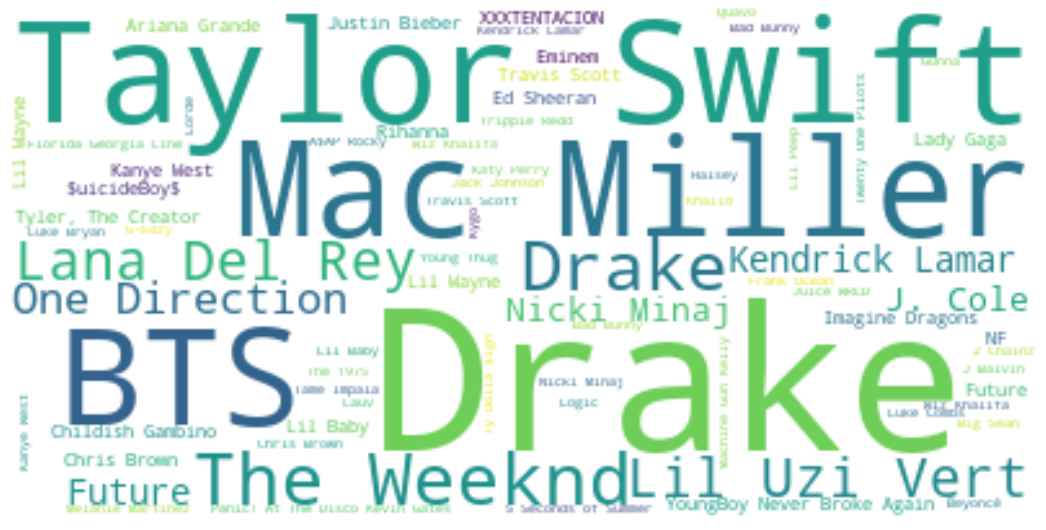

<Figure size 576x396 with 0 Axes>

In [12]:
# creating a dataframe with all artists for tracks that were released 2010 or later
artists = df.query('year>=2010')['artists'].str.strip("[]")
artists = artists.str.split("',", expand=True)

# plotting wordcloud using imported file
plotting.wc(artists)
plt.savefig('figures/artist_2010_wc.png')

### No of artists

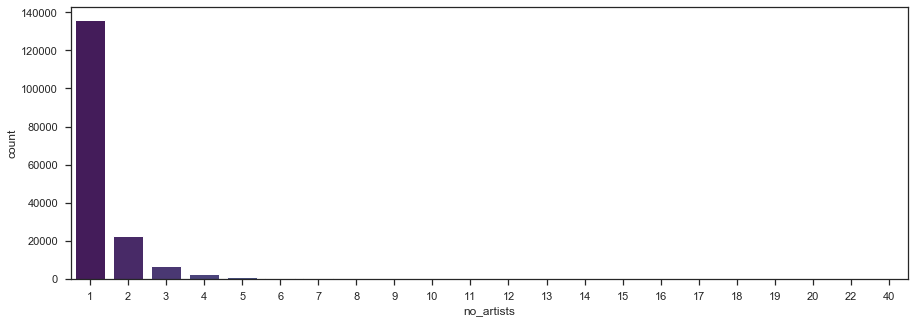

In [28]:
# reformating from sting to list
df['artists_list'] = df['artists'].apply(lambda x: literal_eval(x))

# counting artists in list
df['no_artists'] = df['artists_list'].str.len()

# plotting
plt.figure(figsize=(15,5))
chart = sns.countplot(x='no_artists',data=df, palette='viridis');
chart.set_xticklabels(chart.get_xticklabels(), rotation=0);
plt.savefig('figures/no_artists_1920_hist.png')

In [29]:
df[df['no_artists']>5].shape

(1108, 24)

## Genres

### Matching artists' genres

In [30]:
# creating a dataframe with all artists
artists = df['artists'].str.strip("[]")
artists = pd.DataFrame(artists.str.split("',", expand=True))

# matching genres to the first five artists in the lists
for i in range(5):
    df['artist_' + str(i + 1)] = artists[i].str.replace("'", "")
    df = pd.merge(df,
                  data_genre[['artists', 'genres']],
                  how='left',
                  left_on='artist_' + str(i + 1),
                  right_on='artists')
    df.drop('artists_y', inplace=True, axis=1)
    df.rename(columns={'artists_x': 'artists', 'genres': 'genres_' + str(i + 1)}, inplace=True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169909 entries, 0 to 169908
Data columns (total 34 columns):
acousticness        169909 non-null float64
artists             169909 non-null object
danceability        169909 non-null float64
duration_ms         169909 non-null int64
energy              169909 non-null float64
explicit            169909 non-null int64
id                  169909 non-null object
instrumentalness    169909 non-null float64
key                 169909 non-null int64
liveness            169909 non-null float64
loudness            169909 non-null float64
mode                169909 non-null int64
name                169909 non-null object
popularity          169909 non-null int64
release_date        169909 non-null object
speechiness         169909 non-null float64
tempo               169909 non-null float64
valence             169909 non-null float64
year                169909 non-null int64
age                 169909 non-null int64
decade              169909 

As can be seen there is no data available in the dataset for artists that are not the first ones in the lists. 

### Since 1920

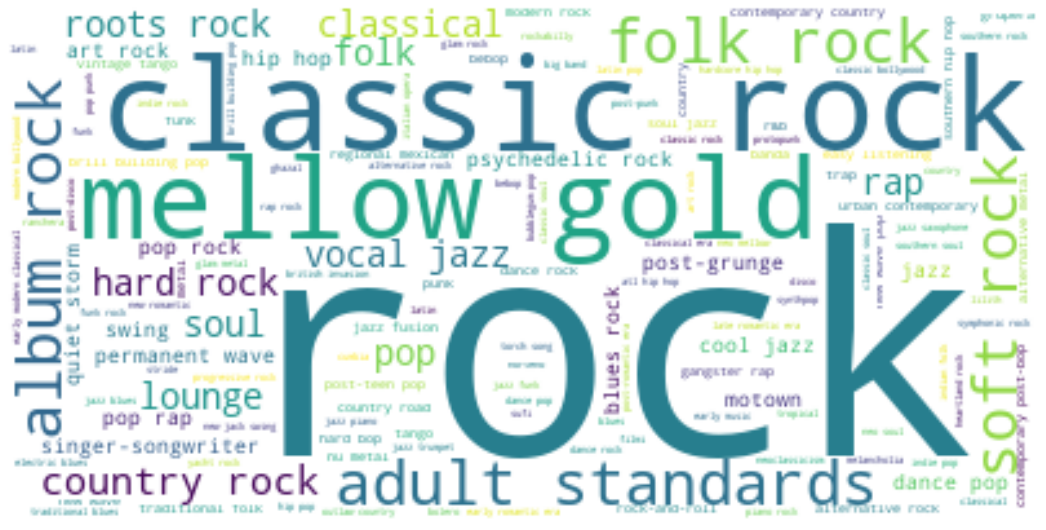

<Figure size 576x396 with 0 Axes>

In [32]:
# creating a dataframe with all genres
genres = df['genres_1'].str.strip("[]")
genres = genres.str.split("',", expand=True)

# plotting wordcloud using imported file
plotting.wc(genres)
plt.savefig('figures/genres_1920_wc.png')

### Since 2010

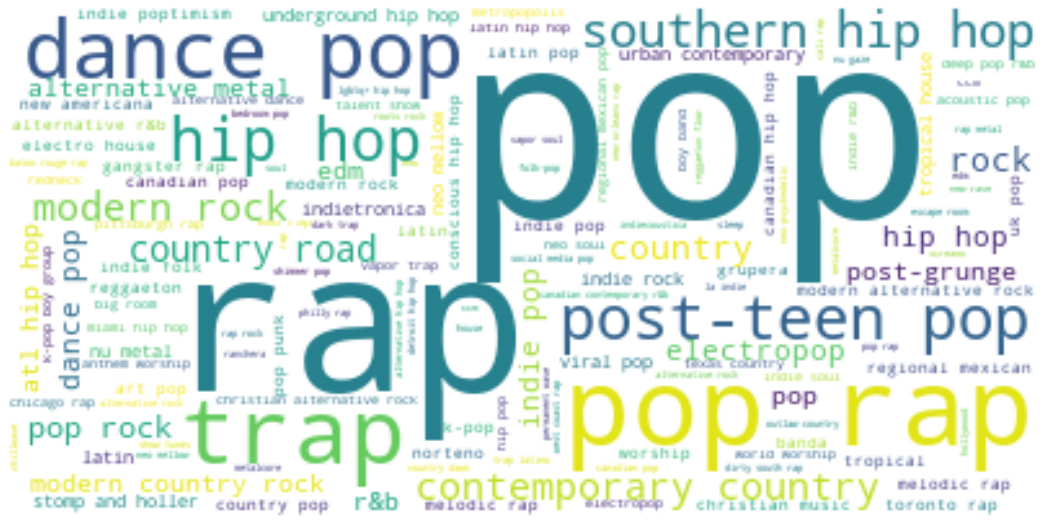

<Figure size 576x396 with 0 Axes>

In [33]:
# creating a dataframe with all gernres of tracks that were released 2010 or later
genres = df.query('year>=2010')['genres_1'].str.strip("[]")
genres = genres.str.split("',", expand=True)

# plotting wordcloud using imported file
plotting.wc(genres)
plt.savefig('figures/genres_2010_wc.png')

### No of genres

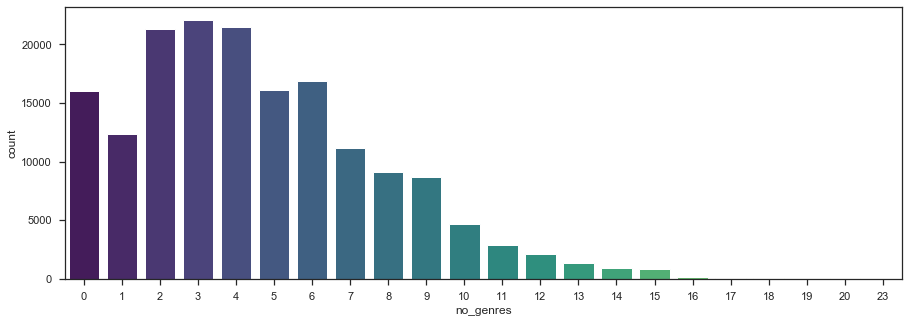

In [38]:
# reformating from sting to list
df.dropna(subset=['genres_1'], inplace=True)
df.loc[:,'genres_1'] = df.loc[:,'genres_1'].apply(lambda x: literal_eval(x))

# counting artists in list
df['no_genres'] = df['genres_1'].str.len()

# plotting
plt.figure(figsize=(15,5))
chart = sns.countplot(x='no_genres',data=df, palette='viridis');
chart.set_xticklabels(chart.get_xticklabels(), rotation=0);
plt.savefig('figures/no_genres_1920_hist.png')

## Duration, loudness & tempo

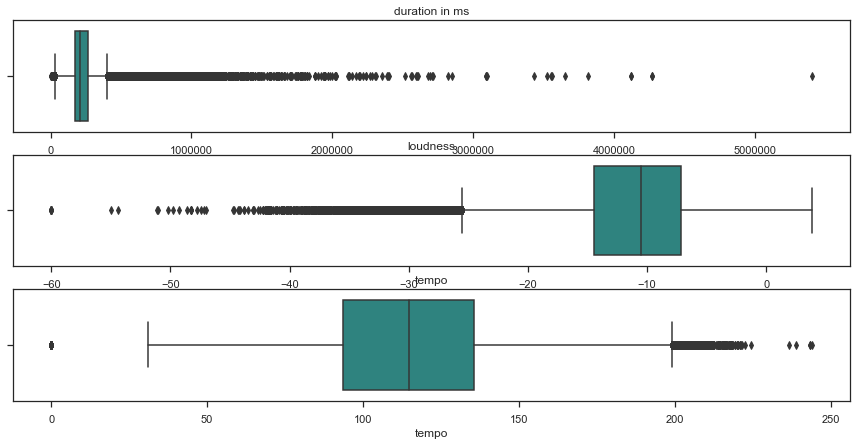

In [40]:
# plotting distribution via boxplots
f, axes = plt.subplots(3, 1, figsize=(15, 7), sharex=False)
plt.tight_layout()
sns.boxplot(df['duration_ms'], palette='viridis',ax=axes[0]).set_title('duration in ms');
sns.boxplot(df['loudness'], palette='viridis',ax=axes[1]).set_title('loudness');
sns.boxplot(df['tempo'], palette='viridis',ax=axes[2]).set_title('tempo');
plt.savefig('figures/duration_loudness_tempo_1920_box.png')

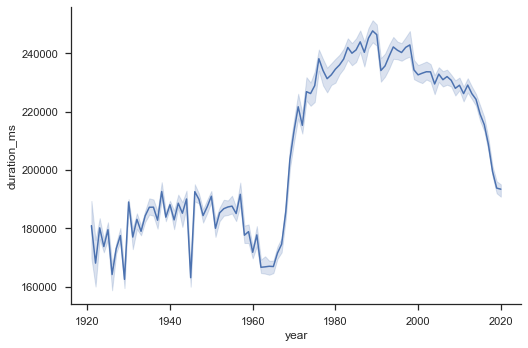

In [41]:
# plotting track duration development over time using imported file
plotting.year_plot("duration_ms", df);

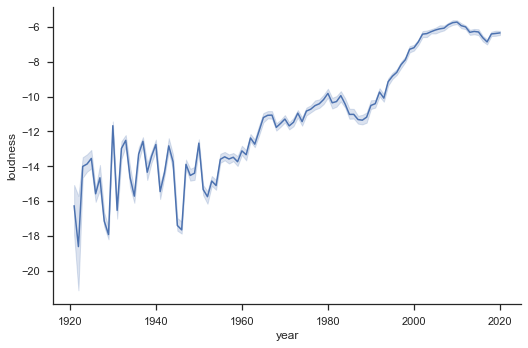

In [42]:
# plotting loudness development over time using imported file
plotting.year_plot("loudness", df)

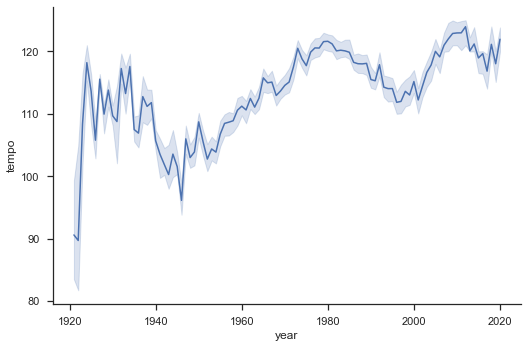

In [43]:
# plotting tempo development over time using imported file
plotting.year_plot("tempo",df)

## Explicity

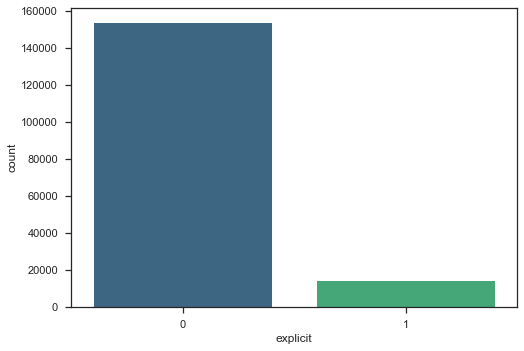

In [44]:
# plotting
sns.countplot(df['explicit'], palette='viridis');
plt.savefig('figures/explicit_1920_hist.png')

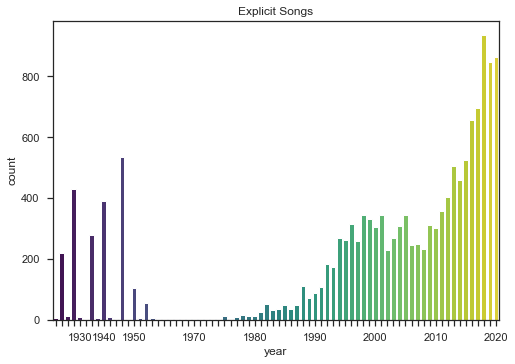

In [45]:
# creating dataframe with explicit tracks only
explicit = df.query('explicit == 1')

# plotting
chart = sns.countplot(explicit['year'], palette='viridis')

# reducing visible labels
for label in chart.xaxis.get_ticklabels():
    if float(label.get_text())%10!=0:
        label.set_visible(False)

plt.title("Explicit Songs")
plt.savefig('figures/year_explicit_1920_bar.png')
plt.show()


Although overall there are only very few explicit tracks in the dataset there is a clear trend towards more explicit tracks as time moves along after 1960. Before 1960, there are no visible trends, possibly due to the amount of data available in these years.

## Key

/Users/vivika/opt/anaconda3/envs/nf/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 9837 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/vivika/opt/anaconda3/envs/nf/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 9837 missing from current font.
  font.set_text(s, 0, flags=flags)


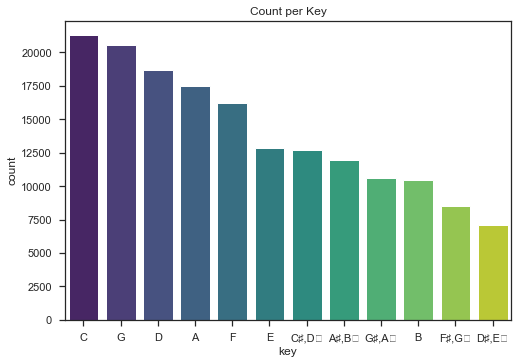

In [46]:
# mapping the numeric values of key to notes
key_mapping = {0.0: 'C', 1.0: 'C♯,D♭', 2.0: 'D', 3.0: 'D♯,E♭', 4.0: 'E', 5.0: 'F', 6.0: 'F♯,G♭', 7.0: 'G', 8.0: 'G♯,A♭', 9.0: 'A', 10.0: 'A♯,B♭', 11.0: 'B'}
df['key'] = df['key'].map(key_mapping)

# plotting
sns.countplot(x = 'key', data=df, order=df['key'].value_counts().index, palette='viridis')
plt.title("Count per Key")
plt.savefig('figures/key_1920_hist.png')
plt.show()

## Mode

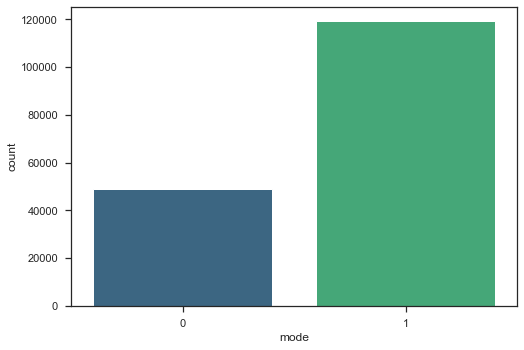

In [47]:
# plotting
sns.countplot(df['mode'], palette='viridis');
plt.savefig('figures/mode_1920_hist.png')

## Correlations

In [1]:
%ls

Data/                                  Spotify5_Classification_200812.ipynb
Figures/                               Spotify6_Clustering_200812.ipynb
Notebooks/                             Spotify7_App_200812.ipynb
Pickles/                               Weights-010--7.24545.hdf5
README.md                              __pycache__/
Spotify1_100yrs_EDA_200812.ipynb       alt/
Spotify2_Additional_Data_200812.ipynb  plotting.ipynb
Spotify3_2019_EDA_200812.ipynb         plotting.py
Spotify4_Regression_200812.ipynb       snippets.ipynb


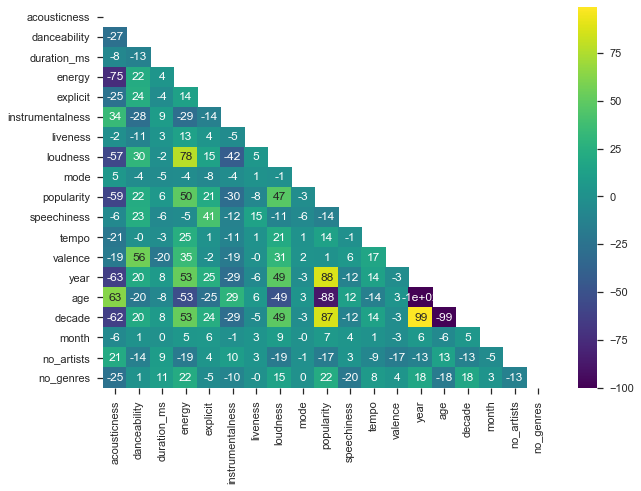

In [49]:
# plotting correlations between features and label
mask = np.triu(df.corr())
plt.figure(figsize = (10,7))
ax = sns.heatmap(round(df.corr()*100)
                 ,annot=True
                 ,mask=mask
                 ,cmap='viridis')
plt.savefig('figures/1920_correlogram.png')